<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

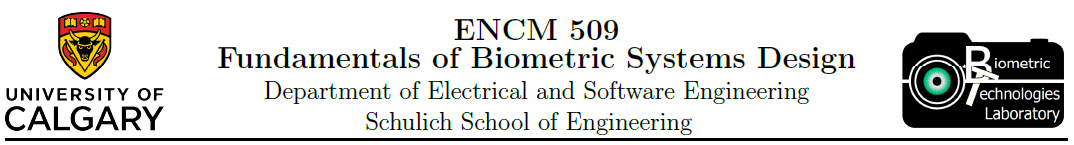

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

# Exercise 1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, plase open you Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

# custom functions
from utils.blockproc import blockproc

## Auxiliary Functions

In [24]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

# create the filter according to the size of the image
def gabor_template_freq_up(im, angle, freq=0.2):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

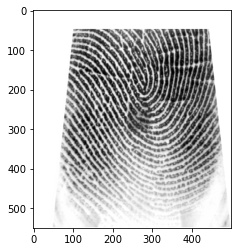

In [25]:
## First we read the image thne we will perform the gabor filtering
img = imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True)
plt.imshow(img, cmap='gray');

## Frequency Adjustment 1 (0.11)

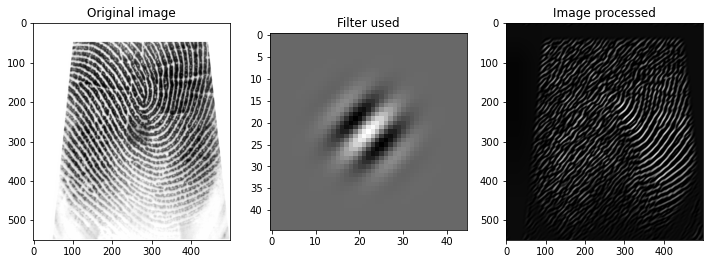

In [26]:
fi1 = gabor_template(img, angle=np.pi/4)
img_f1 = gabor_filtering(img, fi1)
                         
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi1, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f1, cmap='gray'); plt.title('Image processed');

## Frequency Adjustment (0.2)

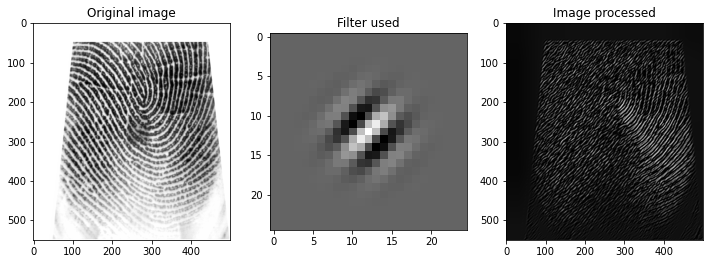

In [27]:
fi2 = gabor_template_freq_up(img, angle=np.pi/4)
img_f2 = gabor_filtering(img, fi2)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi2, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f2, cmap='gray'); plt.title('Image processed');

## Conclusion

Visually speaking, when the frequency parameter is tuned up, the resolution of the gabor filter decreases (less pixels). The resolution of the image with th efilter applied seems to have a higher resolution, and appears more detailed. Based on the parameter adjustment applying a filter with a higher frequency seems to produce a higher resolution filtered image.

## Angle Adjustment $\pi/8$

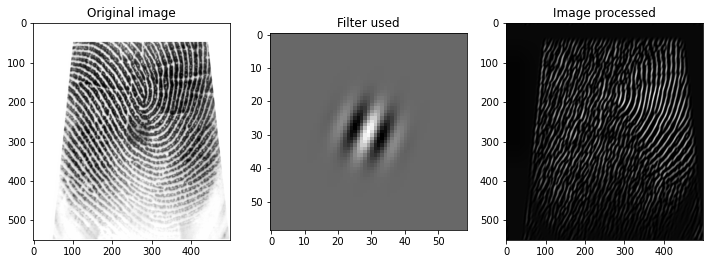

In [28]:
fi3 = gabor_template(img, angle=np.pi/8)
img_f3 = gabor_filtering(img, fi3)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi3, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f3, cmap='gray'); plt.title('Image processed');

## Angle Adjustment $-\pi/8$

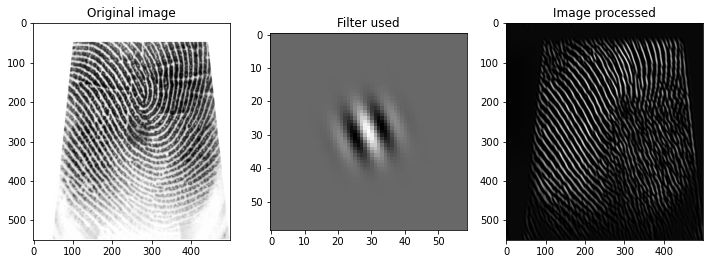

In [29]:
fi4 = gabor_template(img, angle=-np.pi/8)
img_f4 = gabor_filtering(img, fi4)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi4, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f4, cmap='gray'); plt.title('Image processed');

## Conclusion

Changing the angle of the gabor filter visually rotates the gabor filter **angle** degrees to the right or left depending on the sign in front of the angle. Depending on the orientation of the filter, the image is filtered so that it only shows ridges that are similarly oriented. It can be concluded that for any given gabor filter angle, the orientation of the visible ridges on the image will resemble the orientation of the filter used.

# Exercise 2

Auxiliary Function for processing

In [30]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [32]:
gallery = []

for i in range(9):
    raw_img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % (i+1), as_gray=True))
    gallery.append(fingerprint_processing(raw_img))
    
probe = fingerprint_processing(img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/10.bmp', as_gray=True)))
    

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4
Total of minutiae detected: 89
Total of singularities detected: 4
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 79
Total of singularities detected: 0
Total of minutiae detected: 44
Total of singularities detected: 0
Total of minutiae detected: 28
Total of singularities detected: 0
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 50
Total of singularities detected: 0
Total of minutiae detected: 50
Total of singularities detected: 4


In [34]:
for i in range(9):
    img = gallery[i]
    imSkeletonAlign, minutiaArrayAlign = align2(probe, img)
    img['imSkeletonAlign'] = imSkeletonAlign
    img['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probe, img, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))
    

number of matched minutiae: 7
distance total computed : 31
number of minutiae in input image: 386
number of minutiae in database image: 60
score for minutiae: 0.0314

number of matched minutiae: 5
distance total computed : 18
number of minutiae in input image: 748
number of minutiae in database image: 60
score for minutiae: 0.0124

number of matched minutiae: 3
distance total computed : 12
number of minutiae in input image: 767
number of minutiae in database image: 60
score for minutiae: 0.0073

number of matched minutiae: 3
distance total computed : 16
number of minutiae in input image: 503
number of minutiae in database image: 60
score for minutiae: 0.0107

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
score for minutiae: 0.0000

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
score for minutiae: 0.0000

numb

The above 1 to 1 matching loop gave abnormal scores for images 5, 6, 7, and a 9. As a result we will perform 4 more 1 to one matches to compensate for the outliers above.

In [51]:
galleryredo = []

for i in range(4):
    raw_img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % (i+15), as_gray=True))
    galleryredo.append(fingerprint_processing(raw_img))
    
probe = fingerprint_processing(img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/10.bmp', as_gray=True)))

Total of minutiae detected: 61
Total of singularities detected: 4
Total of minutiae detected: 49
Total of singularities detected: 6
Total of minutiae detected: 76
Total of singularities detected: 2
Total of minutiae detected: 43
Total of singularities detected: 0
Total of minutiae detected: 50
Total of singularities detected: 4


In [52]:
for i in range(4):
    img = galleryredo[i]
    imSkeletonAlign, minutiaArrayAlign = align2(probe, img)
    img['imSkeletonAlign'] = imSkeletonAlign
    img['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probe, img, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))
    

number of matched minutiae: 10
distance total computed : 53
number of minutiae in input image: 997
number of minutiae in database image: 60
score for minutiae: 0.0189

number of matched minutiae: 5
distance total computed : 22
number of minutiae in input image: 297
number of minutiae in database image: 60
score for minutiae: 0.0280

number of matched minutiae: 2
distance total computed : 9
number of minutiae in input image: 683
number of minutiae in database image: 60
score for minutiae: 0.0054

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
score for minutiae: 0.0000



| image | score against probe |
|---|---|
| image 1 | 0.0314 |
| image 2 | 0.0124 |
| image 3 | 0.0073 |
| image 4 | 0.0107 |
| image 5 | 0.1147 |
| image 6 | 0.0189 |
| image 7 | 0.0280 |
| image 8 | 0.0054 |
| image 9 | 0.0000 (outlier) |

Our top three scores are 0.1147, 0.0314, and 0.0280. Let us choose the threshold to be 0.0280. That would leave us with 1 TP, 2 FP, 6 TN and 0 FN. Manipulating the threshold would adjust what we would consider to be a TP, TN, FP, and FN. For example, we set the threshold to 0.0107, we get 1 TP, 5FP, 3 TN, and 0 FN.

# Exercise 3

In [46]:
gallery2 = []

for i in range(9):
    gallery2.append(imread('BTLab_Fingerprints/right_thumb/%d.bmp' % (i+1), as_gray=True))
    
probe2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/10.bmp', as_gray=True))
    

In [37]:
for i in range(9):
    img = gallery2[i]

    score2 = MatchGaborFeat(probe, gallery2[i])
    print('Score using Gabor features: %.4f' % (score2))

Score using Gabor features: 26.7024
Score using Gabor features: 26.7019
Score using Gabor features: 26.7023
Score using Gabor features: 26.7047
Score using Gabor features: 26.7045
Score using Gabor features: 26.7039
Score using Gabor features: 26.7051
Score using Gabor features: 26.7038
Score using Gabor features: 26.7037


| image | score against probe |
|---|---|
| image 1 | 26.7024 |
| image 2 | 26.7019 |
| image 3 | 26.7023 |
| image 4 | 26.7047 |
| image 5 | 26.7045 |
| image 6 | 26.7039 |
| image 7 | 26.7051 |
| image 8 | 26.7038 |
| image 9 | 26.7037 |

Again we choose the threshold as 26.7045. That leaves us with 1 TP, 2 FP, 6 TN, and 0 FN. The threshold adjustment once again would cause us to consider a TP differently. Decreasing the threshold would create more FP, while increasing it would have more matches be considered TN.

# Exercise 4

In [54]:
ex4gal = []

for i in range(9):
    raw_img = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/%d.bmp' % (i+1), as_gray=True))
    ex4gal.append(fingerprint_processing(raw_img))
    
# the true match
ex4gal.append(fingerprint_processing(img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))))
# the probe used that matches the one in the gallery
probeex4 = fingerprint_processing(img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))) 
    

Total of minutiae detected: 52
Total of singularities detected: 4
Total of minutiae detected: 91
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4
Total of minutiae detected: 120
Total of singularities detected: 4
Total of minutiae detected: 69
Total of singularities detected: 4
Total of minutiae detected: 62
Total of singularities detected: 4
Total of minutiae detected: 44
Total of singularities detected: 4
Total of minutiae detected: 48
Total of singularities detected: 2
Total of minutiae detected: 69
Total of singularities detected: 4
Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 47
Total of singularities detected: 4


In [55]:
for i in range(10):
    img = ex4gal[i]
    imSkeletonAlign, minutiaArrayAlign = align2(probeex4, img)
    img['imSkeletonAlign'] = imSkeletonAlign
    img['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(probeex4, img, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))
    

number of matched minutiae: 1
distance total computed : 5
number of minutiae in input image: 475
number of minutiae in database image: 64
score for minutiae: 0.0037

number of matched minutiae: 2
distance total computed : 6
number of minutiae in input image: 1526
number of minutiae in database image: 64
score for minutiae: 0.0025

number of matched minutiae: 6
distance total computed : 28
number of minutiae in input image: 757
number of minutiae in database image: 64
score for minutiae: 0.0146

number of matched minutiae: 6
distance total computed : 25
number of minutiae in input image: 1085
number of minutiae in database image: 64
score for minutiae: 0.0104

number of matched minutiae: 2
distance total computed : 10
number of minutiae in input image: 618
number of minutiae in database image: 64
score for minutiae: 0.0059

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 221
number of minutiae in database image: 64
score for minutiae: 0.0000


| rank | image | score against probe |
|---|---|---|
| 1 | image 10 | 0.2844 |
| 2 | image 8 | 0.0319 |
| 3 | image 7 | 0.0173 |
| 4 | image 3 | 0.0146 |
| 5 | image 4 | 0.0104 |
| 6 | image 9 | 0.0103 |
| 7 | image 5 | 0.0059 |
| 8 | image 1 | 0.0037 |
| 9 | image 2 | 0.0025 |
| 10 | image 6 | 0.0000 |

Since our true match has the number 1 score we choose it to be the threshold. The threshold being 0.2844 means that we are left with 1 TP and 9 TN. Since we know that image 10 is the correct match to the probe, we can be sure that all other images are a mismatch. This is consistant with image 10 having the top ranked score. if image 10 had fallen to rank 3 for example, we would be left with 2 FP, 1 TP, and 6 TN. The choice of threshold determines what we consider to be a TN. It determines how we classify other comparisons based on the chosen threshold. Threshold adjustment can vary the accuracy of your system since it changes the ratio of classifications made by the system.